## Terrain data

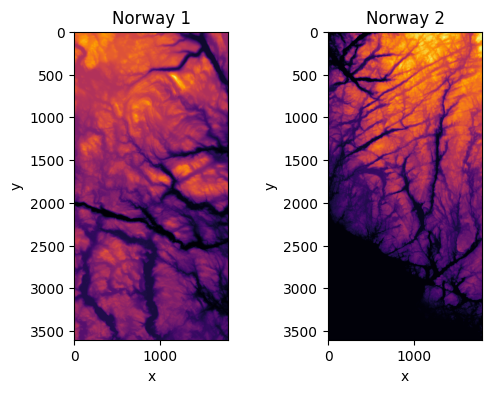

In [72]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import Ridge
import imageio.v2
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# nepal_1 = imageio.v2.imread("nepal_1.tif")
# nepal_2 = imageio.v2.imread("nepal_2.tif")
norway_1 = imageio.v2.imread("SRTM_data_Norway_1.tif")
norway_2 = imageio.v2.imread("SRTM_data_Norway_2.tif")

#Plotting
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].imshow(norway_1, cmap='inferno')
ax[0].set_title("Norway 1")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].imshow(norway_2, cmap='inferno')
ax[1].set_title("Norway 2")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

# plt.tight_layout()
plt.show()

(3601, 1801)
(3601, 1801)


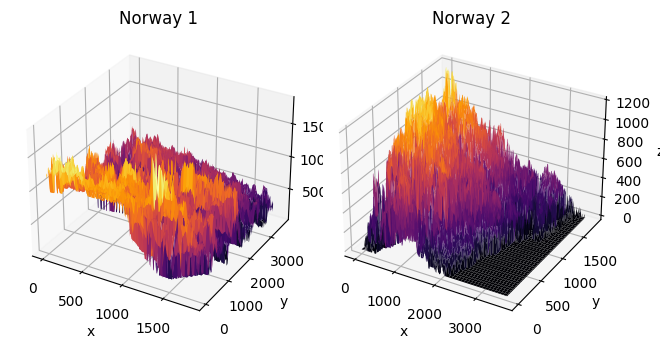

In [73]:
#Surface plots
x1_norway = np.linspace(0, norway_1.shape[1]-1, norway_1.shape[1])
y1_norway = np.linspace(0, norway_1.shape[0]-1, norway_1.shape[0])
xx1_norway, yy1_norway = np.meshgrid(x1_norway, y1_norway)

x2 = np.linspace(0, norway_2.shape[0]-1, norway_2.shape[0])
y2 = np.linspace(0, norway_2.shape[1]-1, norway_2.shape[1])
xx2, yy2 = np.meshgrid(x2, y2)

# print(nepal_1.shape)
# print(nepal_2.shape)
print(norway_1.shape)
print(norway_2.shape)


#Plotting
fig = plt.figure()

ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(xx1_norway, yy1_norway, norway_1, cmap='inferno')
ax1.set_title("Norway 1")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(xx2, yy2, norway_2.T, cmap='inferno')
ax2.set_title("Norway 2")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

plt.tight_layout()
plt.show()

100%|██████████| 34/34 [11:07<00:00, 19.63s/it]




MSE: [0.018258445264446383, 0.017624436994339777, 0.01693126241029863, 0.01662309511041149, 0.015631737144052707, 0.01529573514099458, 0.014202482423032715, 0.013584633949618136, 0.013315914729295079, 0.012541338082434433, 0.012400941826012812, 0.01236981664888303, 0.011890918174039923, 0.01285970109979849, 0.015978431932279758, 0.030904154524798454, 0.013606231274887004, 0.011686744753454166, 0.015377831678343518, 0.01144878540063823, 0.013984794618875786, 0.011085467577400955, 0.01501982985226872, 0.058697392958979626, 0.014113816160283357, 0.011364786614159371, 0.013032974614361016, 0.011716073379263005, 0.33153374395852436, 0.056383433389899235, 0.02472873117914466, 0.010954481078358091, 0.03641243325931108, 0.01440395659609494]
R2: [0.3457773757891024, 0.36849467445462647, 0.39333197515792095, 0.4043739897822841, 0.4398955690235651, 0.4519349354097517, 0.491107529336105, 0.513245802545439, 0.5228743438012482, 0.5506283808631226, 0.5556589519755707, 0.5567742054796863, 0.57393372

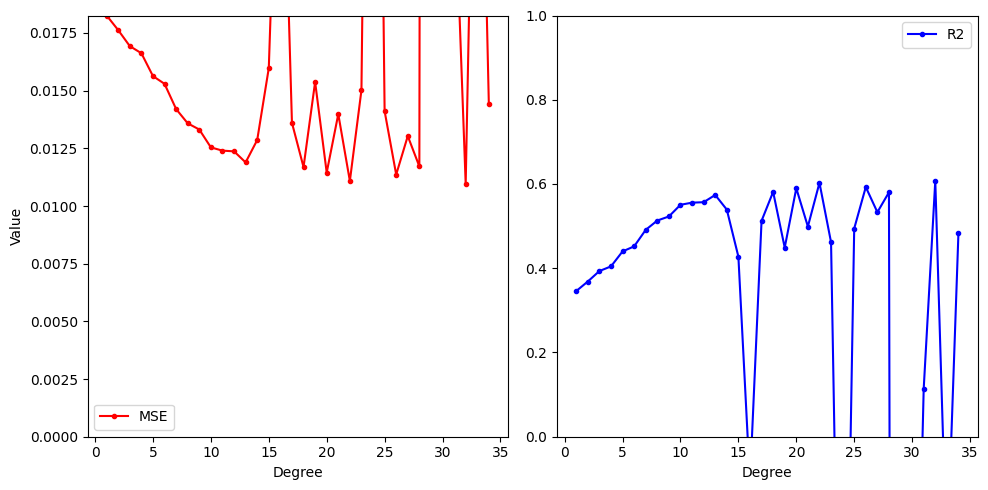

In [74]:
#OLS fitting
def MSE(x, y):
  return np.mean((x-y)**2)

def R2(x, y):
    return 1 - np.sum((x-y)**2)/np.sum((x-np.mean(x))**2)


def design_matrix(x, y, degree):
    num_terms = (degree+1)*(degree+2)//2
    X = np.ones((len(x), num_terms))
    k = 0
    for i in range(degree+1):
        for j in range(i+1):
            X[:,k] = (x**(i-j)) * (y**j)
            k += 1
    return X

def OLS_fitting(x_train, x_test, y_train, y_test, z_train, z_test, max_degree):
    X_train = design_matrix(x_train, y_train, max_degree)
    X_test = design_matrix(x_test, y_test, max_degree)

    # Optimal betas
    betas_OLS = np.linalg.solve(X_train.T @ X_train, X_train.T @ z_train)

    # Predictions
    z_tilde = X_test @ betas_OLS
    return betas_OLS, z_tilde, MSE(z_test, z_tilde), R2(z_test, z_tilde)

# Ridge fitting
def Ridge_fitting(x_train, x_test, y_train, y_test, z_train, z_test, max_degree, alpha=1.0):
    X_train = design_matrix(x_train, y_train, max_degree)
    X_test = design_matrix(x_test, y_test, max_degree)

    # Ridge initializer
    ridge = Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(X_train, z_train)

    # Make predictions
    z_tilde = ridge.predict(X_test)
    return ridge.coef_, z_tilde, MSE(z_test, z_tilde), R2(z_test, z_tilde)

def SVD_OLS_fitting(x_train, x_test, y_train, y_test, z_train, z_test, max_degree):
    X_train = design_matrix(x_train, y_train, max_degree)
    X_test = design_matrix(x_test, y_test, max_degree)

    #Use SVD for X
    U, s, Vt = np.linalg.svd(X_train, full_matrices=False)
    S_inv = np.diag(1 / s)

    # Optimal betas
    betas_OLS = Vt.T @ S_inv @ U.T @ z_train

    # Predictions
    z_tilde = X_test @ betas_OLS

    return betas_OLS, z_tilde, MSE(z_test, z_tilde), R2(z_test, z_tilde)

#Make dataset
x = np.linspace(0, norway_1.shape[0]-1, norway_1.shape[0])
y = np.linspace(0, norway_1.shape[1]-1, norway_1.shape[1])
xx, yy = np.meshgrid(x, y)
z = norway_1
x, y, z = xx.ravel(), yy.ravel(), z.ravel()
dataset = np.c_[x, y, z]
dataset = dataset[np.random.choice(dataset.shape[0], size=1_000_000, replace=False)]


#Rescaled data to [0, 1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)
x, y, z = scaled_data[:, 0], scaled_data[:, 1], scaled_data[:, 2]

#Train-test splitting
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

#Some fixed Fitting
# _ = OLS_fitting(x_train, x_test, y_train, y_test, z_train, z_test, 15)
# _Rid = Ridge_fitting(x_train, x_test, y_train, y_test, z_train, z_test, 14, alpha=0.1)

msqerr = []
r2_score = []
betas_OLS = []
z_preds = []
max_degree = 35
for i in tqdm(range(1, max_degree)):
  betas, z_tilde, mse, r2 = OLS_fitting(x_train, x_test, y_train, y_test, z_train, z_test, i)
  msqerr.append(mse)
  r2_score.append(r2)
  betas_OLS.append(betas)
  z_preds.append(z_tilde)

print("\n")
print("MSE:", msqerr)
print("R2:", r2_score)
print("Minimum MSE at degree:", np.argmin(msqerr)+1, "with ", msqerr[np.argmin(msqerr)])
print("Maximum R2 score at degree:", np.argmax(r2_score)+1, "with ", r2_score[np.argmax(r2_score)])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, max_degree), msqerr, "ro-", ms=3, label="MSE")
ax[0].set_ylim(0, msqerr[0])
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Value")
ax[0].legend()

ax[1].plot(range(1, max_degree), r2_score, "bo-", ms=3, label="R2")
ax[1].set_xlabel("Degree")
ax[1].set_ylim(0, 1)
ax[1].legend()

plt.tight_layout()
plt.show()

Data length:  200000


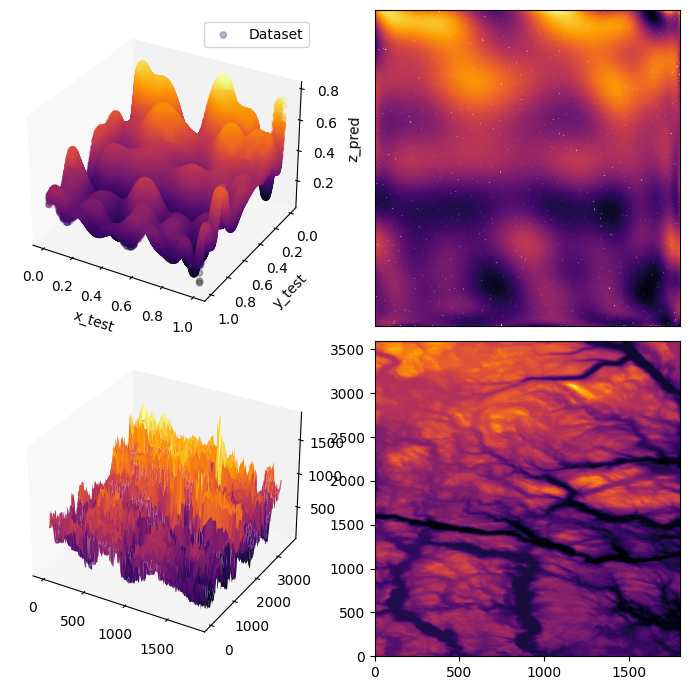

<Figure size 640x480 with 0 Axes>

In [75]:
#Scale data again
z_pred = z_preds[np.argmin(msqerr)]
print("Data length: ", len(z_pred))

# Setup
fig = plt.figure(figsize=(7, 7))

# Plot (1,1) - Scatter - Model
ax_3d_1 = fig.add_subplot(2, 2, 1, projection='3d')
sc = ax_3d_1.scatter(x_test, y_test, z_pred, c=z_pred, marker='o', label="Dataset", alpha=0.3, cmap='inferno')
ax_3d_1.set_xlabel('x_test')
ax_3d_1.set_ylabel('y_test')
ax_3d_1.set_zlabel('z_pred')
ax_3d_1.invert_yaxis()
ax_3d_1.legend()
ax_3d_1.xaxis.pane.set_edgecolor('none')
ax_3d_1.yaxis.pane.set_edgecolor('none')
ax_3d_1.zaxis.pane.set_edgecolor('none')
ax_3d_1.grid(False)

# Plot (2,1) - Norwegian surface
ax_3d_2 = fig.add_subplot(2, 2, 3, projection='3d')
surf1 = ax_3d_2.plot_surface(xx1_norway, yy1_norway, np.flip(norway_1, axis=0), cmap='inferno')
ax_3d_2.xaxis.pane.set_edgecolor('none')
ax_3d_2.yaxis.pane.set_edgecolor('none')
ax_3d_2.zaxis.pane.set_edgecolor('none')
ax_3d_2.grid(False)

# Plot (1,2) - Heatmap Model (Hexbin plot)
ax_2d_1 = fig.add_subplot(2, 2, 2)
ax_2d_1.hexbin(x_test, y_test, C=z_pred, gridsize=500, cmap='inferno')
ax_2d_1.set_xticks([])
ax_2d_1.set_yticks([])
ax_2d_1.set_xlim(min(x_test), max(x_test))
ax_2d_1.set_ylim(min(y_test), max(y_test))
plt.gca().invert_yaxis()

# Plot (2,2) - Norwegian terrain heatmap (imshow plot)
ax_2d_2 = fig.add_subplot(2, 2, 4)
ax_2d_2.imshow(norway_1, cmap='inferno', extent=[0, norway_1.shape[1], 0, norway_1.shape[0]], aspect="auto")
# ax_2d_2.set_xticks([])
# ax_2d_2.set_yticks([])


plt.tight_layout()
plt.savefig("Results.png")
plt.show()